<a href="https://colab.research.google.com/github/busraparlakk/Oryantasyon-Final-Odevi/blob/main/Hitters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MLB Hitters Salary Prediction - Regresyon Analizi
# Veri Seti: GitHub'dan Hitters dataseti

# Gerekli k√ºt√ºphaneleri y√ºkle

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn k√ºt√ºphaneleri
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy import stats
!pip install catboost
# Diƒüer modeller i√ßin
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
print("K√ºt√ºphaneler ba≈üarƒ±yla y√ºklendi!")

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 99.2/99.2 MB 8.8 MB/s eta 0:00:00
K√ºt√ºphaneler ba≈üarƒ±yla y√ºklendi!


1. VERƒ∞ Y√úKLEME VE KE≈ûFETME

 GitHub'dan veri setini y√ºkle

In [3]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv"
df = pd.read_csv(url)

print("=== VERƒ∞ SETƒ∞ HAKKINDA GENEL Bƒ∞LGƒ∞LER ===")
print(f"Veri seti boyutu: {df.shape}")
print(f"S√ºtun sayƒ±sƒ±: {df.shape[1]}")
print(f"Satƒ±r sayƒ±sƒ±: {df.shape[0]}")
print("\nƒ∞lk 5 satƒ±r:")
print(df.head())

print("\n=== VERƒ∞ Tƒ∞PLERƒ∞ VE EKSƒ∞K VERƒ∞LER ===")
print(df.info())

print("\n=== EKSƒ∞K VERƒ∞ ANALƒ∞Zƒ∞ ===")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Eksik Veri Sayƒ±sƒ±': missing_data,
    'Eksik Veri Y√ºzdesi': missing_percent
})
print(missing_df[missing_df['Eksik Veri Sayƒ±sƒ±'] > 0])

print("\n=== HEDEF DEƒûƒ∞≈ûKEN (SALARY) ANALƒ∞Zƒ∞ ===")
print(f"Salary s√ºtunundaki eksik veri sayƒ±sƒ±: {df['Salary'].isnull().sum()}")
print(f"Salary istatistikleri:")
print(df['Salary'].describe())

=== VERƒ∞ SETƒ∞ HAKKINDA GENEL Bƒ∞LGƒ∞LER ===
Veri seti boyutu: (322, 20)
S√ºtun sayƒ±sƒ±: 20
Satƒ±r sayƒ±sƒ±: 322

ƒ∞lk 5 satƒ±r:
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   

   CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague  
0    29      14      A        E      446       33      20     NaN         A  
1   414     375      N        W      632       43      10   475.0         N  
2   266     263      A        W      880       82      14   480.0         A  
3   838     354      N        E      200       11       3   500.0         N 

2. VERƒ∞ √ñN ƒ∞≈ûLEME

In [4]:
print("\n" + "="*50)
print("VERƒ∞ √ñN ƒ∞≈ûLEME A≈ûAMASI")
print("="*50)

# Eksik verileri analiz et
df_cleaned = df.copy()

# Salary eksik olan kayƒ±tlarƒ± √ßƒ±kar (hedef deƒüi≈üken)
initial_rows = len(df_cleaned)
df_cleaned = df_cleaned.dropna(subset=['Salary'])
removed_rows = initial_rows - len(df_cleaned)
print(f"Salary eksik olan {removed_rows} kayƒ±t √ßƒ±karƒ±ldƒ±.")

# Diƒüer eksik verileri doldur
# Sayƒ±sal s√ºtunlar i√ßin medyan ile doldur
numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if col != 'Salary' and df_cleaned[col].isnull().sum() > 0:
        median_value = df_cleaned[col].median()
        df_cleaned[col].fillna(median_value, inplace=True)
        print(f"{col} s√ºtunundaki eksik veriler medyan ({median_value:.2f}) ile dolduruldu.")

# Kategorik s√ºtunlar i√ßin mod ile doldur
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df_cleaned[col].isnull().sum() > 0:
        mode_value = df_cleaned[col].mode()[0]
        df_cleaned[col].fillna(mode_value, inplace=True)
        print(f"{col} s√ºtunundaki eksik veriler mod ({mode_value}) ile dolduruldu.")

print(f"\nTemizleme sonrasƒ± veri seti boyutu: {df_cleaned.shape}")

# Kategorik deƒüi≈ükenleri encode et
print("\n=== KATEGORƒ∞K DEƒûƒ∞≈ûKEN ENCODING ===")
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()
print(f"Kategorik s√ºtunlar: {categorical_cols}")

# Label Encoding uygula
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le
    print(f"{col} s√ºtunu Label Encoding ile d√∂n√º≈üt√ºr√ºld√º.")



VERƒ∞ √ñN ƒ∞≈ûLEME A≈ûAMASI
Salary eksik olan 59 kayƒ±t √ßƒ±karƒ±ldƒ±.

Temizleme sonrasƒ± veri seti boyutu: (263, 20)

=== KATEGORƒ∞K DEƒûƒ∞≈ûKEN ENCODING ===
Kategorik s√ºtunlar: ['League', 'Division', 'NewLeague']
League s√ºtunu Label Encoding ile d√∂n√º≈üt√ºr√ºld√º.
Division s√ºtunu Label Encoding ile d√∂n√º≈üt√ºr√ºld√º.
NewLeague s√ºtunu Label Encoding ile d√∂n√º≈üt√ºr√ºld√º.


 3. MODELLEME √ñNCESƒ∞ HAZIRLIK

In [5]:
print("\n" + "="*50)
print("MODELLEME √ñNCESƒ∞ HAZIRLIK")
print("="*50)

# Hedef deƒüi≈üken ve √∂zellikler
target = 'Salary'
features = [col for col in df_cleaned.columns if col != target]

X = df_cleaned[features]
y = df_cleaned[target]

print(f"√ñzellik sayƒ±sƒ±: {len(features)}")
print(f"Hedef deƒüi≈üken: {target}")
print(f"Veri seti boyutu: X={X.shape}, y={y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Eƒüitim seti: {X_train.shape}")
print(f"Test seti: {X_test.shape}")

# √ñzellik √∂l√ßeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("√ñzellikler StandardScaler ile √∂l√ßeklendirildi.")


MODELLEME √ñNCESƒ∞ HAZIRLIK
√ñzellik sayƒ±sƒ±: 19
Hedef deƒüi≈üken: Salary
Veri seti boyutu: X=(263, 19), y=(263,)
Eƒüitim seti: (210, 19)
Test seti: (53, 19)
√ñzellikler StandardScaler ile √∂l√ßeklendirildi.


 4. MODELLEME

In [7]:
print("\n" + "="*50)
print("REGRESYON MODELLERƒ∞")
print("="*50)

# Model tanƒ±mlamalarƒ±
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'CatBoost': CatBoostRegressor(n_estimators=100, random_state=42, verbose=False)
}

# Sonu√ßlarƒ± saklamak i√ßin
results = []

# Her model i√ßin eƒüitim ve deƒüerlendirme
for model_name, model in models.items():
    print(f"\n--- {model_name} ---")

    # √ñl√ßeklendirilmi≈ü veri kullanƒ±lacak modeller
    if model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
        # Model eƒüitimi
    model.fit(X_train_model, y_train)

    # Tahminler
    y_pred_train = model.predict(X_train_model)
    y_pred_test = model.predict(X_test_model)

    # Train-Test Split Metrikleri
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # Cross Validation
    if model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    # Sonu√ßlarƒ± kaydet
    results.append({
        'Model': model_name,
        'Train R2': train_r2,
        'Test R2': test_r2,
        'MAE': test_mae,
        'RMSE': test_rmse,
        'CV R2 Mean': cv_mean,
        'CV R2 Std': cv_std
    })

    print(f"Train R2: {train_r2:.4f}")
    print(f"Test R2: {test_r2:.4f}")
    print(f"MAE: {test_mae:.2f}")
    print(f"RMSE: {test_rmse:.2f}")
    print(f"CV R2: {cv_mean:.4f} (¬±{cv_std:.4f})")



REGRESYON MODELLERƒ∞

--- Linear Regression ---
Train R2: 0.5905
Test R2: 0.2907
MAE: 211.12
RMSE: 358.17
CV R2: 0.3457 (¬±0.3356)

--- Ridge Regression ---
Train R2: 0.5860
Test R2: 0.2994
MAE: 203.68
RMSE: 355.98
CV R2: 0.3797 (¬±0.2717)

--- Lasso Regression ---
Train R2: 0.5865
Test R2: 0.3005
MAE: 203.20
RMSE: 355.71
CV R2: 0.3605 (¬±0.3171)

--- Random Forest ---
Train R2: 0.9463
Test R2: 0.4805
MAE: 183.72
RMSE: 306.55
CV R2: 0.6201 (¬±0.0825)

--- Gradient Boosting ---
Train R2: 0.9876
Test R2: 0.5067
MAE: 181.76
RMSE: 298.72
CV R2: 0.6370 (¬±0.1181)

--- XGBoost ---
Train R2: 1.0000
Test R2: 0.4302
MAE: 204.78
RMSE: 321.03
CV R2: 0.5605 (¬±0.0547)

--- LightGBM ---
Train R2: 0.9290
Test R2: 0.3076
MAE: 186.61
RMSE: 353.89
CV R2: 0.6511 (¬±0.0938)

--- CatBoost ---
Train R2: 0.9937
Test R2: 0.4724
MAE: 177.12
RMSE: 308.91
CV R2: 0.6130 (¬±0.0908)


5. SONU√áLARIN KAR≈ûILA≈ûTIRILMASI

In [8]:
print("\n" + "="*50)
print("MODEL KAR≈ûILA≈ûTIRMASI")
print("="*50)

# Sonu√ßlarƒ± DataFrame'e √ßevir
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test R2', ascending=False)

print("T√ºm Modellerin Performans Kar≈üƒ±la≈ütƒ±rmasƒ±:")
print(results_df.round(4))

# En iyi model
best_model_name = results_df.iloc[0]['Model']
print(f"\nEn iyi performans g√∂steren model: {best_model_name}")



MODEL KAR≈ûILA≈ûTIRMASI
T√ºm Modellerin Performans Kar≈üƒ±la≈ütƒ±rmasƒ±:
               Model  Train R2  Test R2       MAE      RMSE  CV R2 Mean  \
4  Gradient Boosting    0.9876   0.5067  181.7631  298.7191      0.6370   
3      Random Forest    0.9463   0.4805  183.7220  306.5468      0.6201   
7           CatBoost    0.9937   0.4724  177.1224  308.9148      0.6130   
5            XGBoost    1.0000   0.4302  204.7766  321.0317      0.5605   
6           LightGBM    0.9290   0.3076  186.6096  353.8920      0.6511   
2   Lasso Regression    0.5865   0.3005  203.1964  355.7063      0.3605   
1   Ridge Regression    0.5860   0.2994  203.6819  355.9755      0.3797   
0  Linear Regression    0.5905   0.2907  211.1160  358.1680      0.3457   

   CV R2 Std  
4     0.1181  
3     0.0825  
7     0.0908  
5     0.0547  
6     0.0938  
2     0.3171  
1     0.2717  
0     0.3356  

En iyi performans g√∂steren model: Gradient Boosting


 6. G√ñRSELLE≈ûTƒ∞RME


G√ñRSELLE≈ûTƒ∞RME


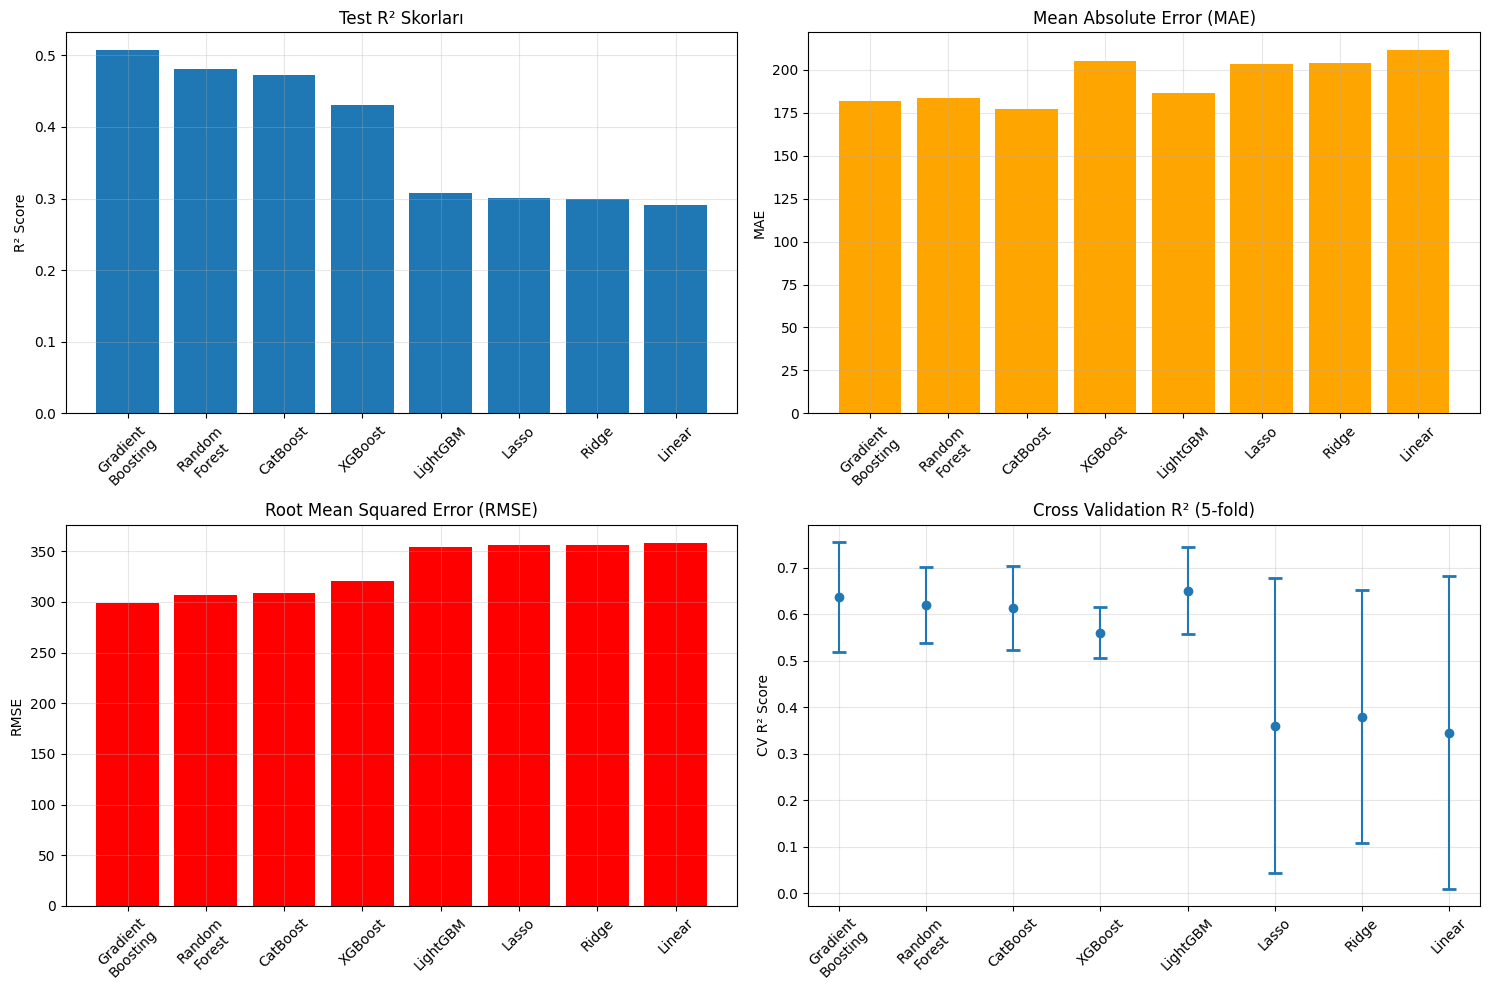

In [9]:
print("\n" + "="*50)
print("G√ñRSELLE≈ûTƒ∞RME")
print("="*50)

# Grafik 1: Model Performans Kar≈üƒ±la≈ütƒ±rmasƒ±
plt.figure(figsize=(15, 10))

# Alt grafik 1: R2 Skorlarƒ±
plt.subplot(2, 2, 1)
models_short = [name.replace(' Regression', '').replace(' ', '\n') for name in results_df['Model']]
plt.bar(models_short, results_df['Test R2'])
plt.title('Test R¬≤ Skorlarƒ±')
plt.ylabel('R¬≤ Score')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Alt grafik 2: MAE Skorlarƒ±
plt.subplot(2, 2, 2)
plt.bar(models_short, results_df['MAE'], color='orange')
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Alt grafik 3: RMSE Skorlarƒ±
plt.subplot(2, 2, 3)
plt.bar(models_short, results_df['RMSE'], color='red')
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Alt grafik 4: Cross Validation R2
plt.subplot(2, 2, 4)
plt.errorbar(range(len(results_df)), results_df['CV R2 Mean'],
             yerr=results_df['CV R2 Std'], fmt='o', capsize=5, capthick=2)
plt.title('Cross Validation R¬≤ (5-fold)')
plt.ylabel('CV R¬≤ Score')
plt.xticks(range(len(results_df)), models_short, rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

7. FEATURE IMPORTANCE (EN ƒ∞Yƒ∞ MODEL ƒ∞√áƒ∞N)


FEATURE IMPORTANCE ANALƒ∞Zƒ∞


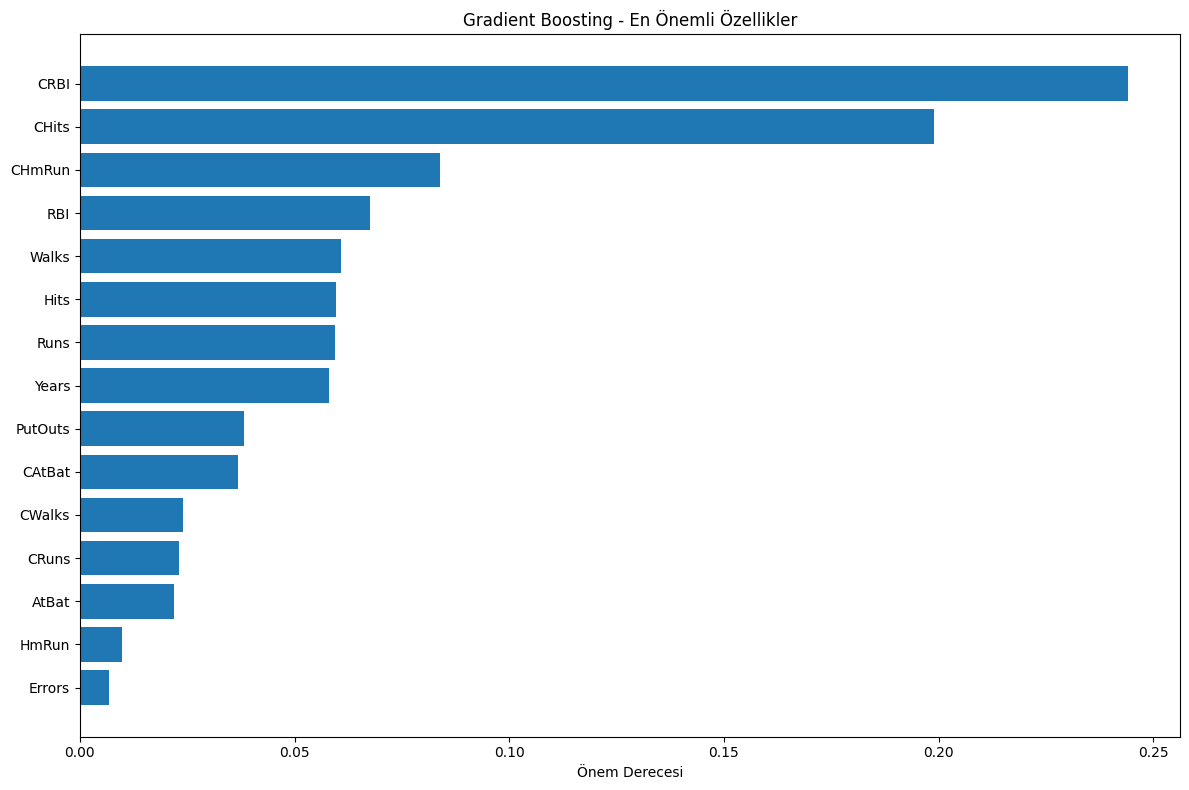

En √∂nemli 10 √∂zellik:
    Feature  Importance
11     CRBI    0.243999
8     CHits    0.198957
9    CHmRun    0.083756
4       RBI    0.067575
5     Walks    0.060756
1      Hits    0.059614
3      Runs    0.059359
6     Years    0.058041
15  PutOuts    0.038325
7    CAtBat    0.036802


In [10]:
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALƒ∞Zƒ∞")
print("="*50)

# En iyi modeli tekrar eƒüit
best_model = models[best_model_name]
if best_model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
    best_model.fit(X_train_scaled, y_train)
    if hasattr(best_model, 'coef_'):
        feature_importance = abs(best_model.coef_)
else:
    best_model.fit(X_train, y_train)
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = best_model.feature_importances_

# Feature importance grafiƒüi
if 'feature_importance' in locals():
    feature_names = X.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)  # En √∂nemli 15 √∂zellik
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.title(f'{best_model_name} - En √ñnemli √ñzellikler')
    plt.xlabel('√ñnem Derecesi')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("En √∂nemli 10 √∂zellik:")
    print(importance_df.head(10))

8. AYKIRI DEƒûER ANALƒ∞Zƒ∞


AYKIRI DEƒûER ANALƒ∞Zƒ∞
Salary deƒüi≈ükeninde 11 aykƒ±rƒ± deƒüer tespit edildi.
Aykƒ±rƒ± deƒüer oranƒ±: 4.18%


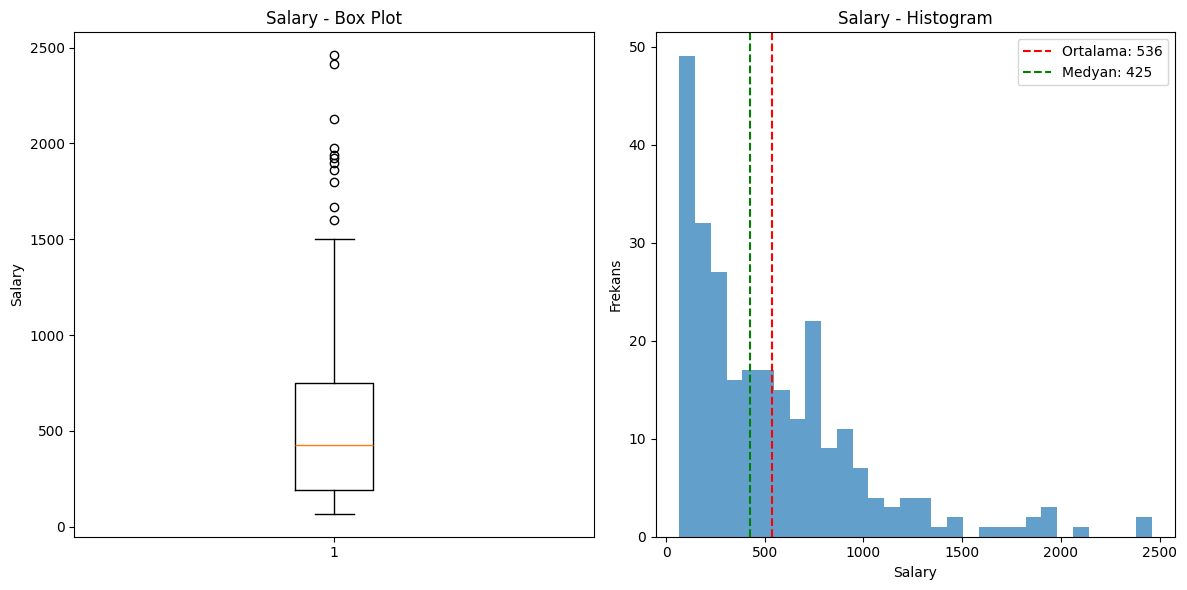

In [11]:
print("\n" + "="*50)
print("AYKIRI DEƒûER ANALƒ∞Zƒ∞")
print("="*50)

# Hedef deƒüi≈üken i√ßin aykƒ±rƒ± deƒüer analizi
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = y[(y < lower_bound) | (y > upper_bound)]
print(f"Salary deƒüi≈ükeninde {len(outliers)} aykƒ±rƒ± deƒüer tespit edildi.")
print(f"Aykƒ±rƒ± deƒüer oranƒ±: {len(outliers)/len(y)*100:.2f}%")

# Aykƒ±rƒ± deƒüerlerin daƒüƒ±lƒ±mƒ±
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.boxplot(y)
plt.title('Salary - Box Plot')
plt.ylabel('Salary')

plt.subplot(1, 2, 2)
plt.hist(y, bins=30, alpha=0.7)
plt.axvline(y.mean(), color='red', linestyle='--', label=f'Ortalama: {y.mean():.0f}')
plt.axvline(y.median(), color='green', linestyle='--', label=f'Medyan: {y.median():.0f}')
plt.title('Salary - Histogram')
plt.xlabel('Salary')
plt.ylabel('Frekans')
plt.legend()

plt.tight_layout()
plt.show()

9. TRAIN-TEST SPLIT vs CROSS VALIDATION KAR≈ûILA≈ûTIRMASI

In [12]:
print("\n" + "="*50)
print("TRAIN-TEST SPLIT vs CROSS VALIDATION KAR≈ûILA≈ûTIRMASI")
print("="*50)

print("Train-Test Split ve Cross Validation arasƒ±ndaki farklar:\n")

for _, row in results_df.iterrows():
    model_name = row['Model']
    test_r2 = row['Test R2']
    cv_r2 = row['CV R2 Mean']
    cv_std = row['CV R2 Std']

    difference = abs(test_r2 - cv_r2)

    print(f"{model_name}:")
    print(f"  Test R¬≤: {test_r2:.4f}")
    print(f"  CV R¬≤: {cv_r2:.4f} (¬±{cv_std:.4f})")
    print(f"  Fark: {difference:.4f}")

    if difference > 0.05:
        print(f"  ‚ö†Ô∏è B√ºy√ºk fark - Model kararsƒ±z olabilir")
    elif cv_std > 0.1:
        print(f"  ‚ö†Ô∏è Y√ºksek standart sapma - Model tutarsƒ±z")
    else:
        print(f"  ‚úÖ Tutarlƒ± performans")
    print()


TRAIN-TEST SPLIT vs CROSS VALIDATION KAR≈ûILA≈ûTIRMASI
Train-Test Split ve Cross Validation arasƒ±ndaki farklar:

Gradient Boosting:
  Test R¬≤: 0.5067
  CV R¬≤: 0.6370 (¬±0.1181)
  Fark: 0.1304
  ‚ö†Ô∏è B√ºy√ºk fark - Model kararsƒ±z olabilir

Random Forest:
  Test R¬≤: 0.4805
  CV R¬≤: 0.6201 (¬±0.0825)
  Fark: 0.1396
  ‚ö†Ô∏è B√ºy√ºk fark - Model kararsƒ±z olabilir

CatBoost:
  Test R¬≤: 0.4724
  CV R¬≤: 0.6130 (¬±0.0908)
  Fark: 0.1406
  ‚ö†Ô∏è B√ºy√ºk fark - Model kararsƒ±z olabilir

XGBoost:
  Test R¬≤: 0.4302
  CV R¬≤: 0.5605 (¬±0.0547)
  Fark: 0.1303
  ‚ö†Ô∏è B√ºy√ºk fark - Model kararsƒ±z olabilir

LightGBM:
  Test R¬≤: 0.3076
  CV R¬≤: 0.6511 (¬±0.0938)
  Fark: 0.3435
  ‚ö†Ô∏è B√ºy√ºk fark - Model kararsƒ±z olabilir

Lasso Regression:
  Test R¬≤: 0.3005
  CV R¬≤: 0.3605 (¬±0.3171)
  Fark: 0.0601
  ‚ö†Ô∏è B√ºy√ºk fark - Model kararsƒ±z olabilir

Ridge Regression:
  Test R¬≤: 0.2994
  CV R¬≤: 0.3797 (¬±0.2717)
  Fark: 0.0803
  ‚ö†Ô∏è B√ºy√ºk fark - Model kararsƒ±z olabilir

Li

10. SMOTE TARTI≈ûMASI

In [13]:
print("\n" + "="*50)
print("SMOTE ANALƒ∞Zƒ∞ VE TARTI≈ûMA")
print("="*50)

print("SMOTE (Synthetic Minority Oversampling Technique) Regresyon ƒ∞√ßin Uygun mu?")
print("\nSMOTE'nin regresyon problemleri i√ßin uygunluƒüu:")
print("‚ùå SMOTE temel olarak sƒ±nƒ±flandƒ±rma problemleri i√ßin tasarlanmƒ±≈ütƒ±r")
print("‚ùå Regresyonda 'azƒ±nlƒ±k sƒ±nƒ±fƒ±' kavramƒ± yoktur")
print("‚ùå S√ºrekli deƒüerler i√ßin sentetik veri √ºretmek daha karma≈üƒ±ktƒ±r")
print("\nRegresyon i√ßin alternatif yakla≈üƒ±mlar:")
print("‚úÖ Aykƒ±rƒ± deƒüerleri √ßƒ±karmak veya d√∂n√º≈üt√ºrmek")
print("‚úÖ Log transformation, Box-Cox transformation")
print("‚úÖ Robust regresyon teknikleri kullanmak")
print("‚úÖ Ensemble y√∂ntemler (Random Forest, Gradient Boosting)")


SMOTE ANALƒ∞Zƒ∞ VE TARTI≈ûMA
SMOTE (Synthetic Minority Oversampling Technique) Regresyon ƒ∞√ßin Uygun mu?

SMOTE'nin regresyon problemleri i√ßin uygunluƒüu:
‚ùå SMOTE temel olarak sƒ±nƒ±flandƒ±rma problemleri i√ßin tasarlanmƒ±≈ütƒ±r
‚ùå Regresyonda 'azƒ±nlƒ±k sƒ±nƒ±fƒ±' kavramƒ± yoktur
‚ùå S√ºrekli deƒüerler i√ßin sentetik veri √ºretmek daha karma≈üƒ±ktƒ±r

Regresyon i√ßin alternatif yakla≈üƒ±mlar:
‚úÖ Aykƒ±rƒ± deƒüerleri √ßƒ±karmak veya d√∂n√º≈üt√ºrmek
‚úÖ Log transformation, Box-Cox transformation
‚úÖ Robust regresyon teknikleri kullanmak
‚úÖ Ensemble y√∂ntemler (Random Forest, Gradient Boosting)


11. GENEL SONU√áLAR VE √ñNERƒ∞LER

In [14]:
print("\n" + "="*50)
print("GENEL SONU√áLAR VE √ñNERƒ∞LER")
print("="*50)

print(f"üèÜ En iyi performans g√∂steren model: {best_model_name}")
print(f"üìä En y√ºksek Test R¬≤: {results_df.iloc[0]['Test R2']:.4f}")
print(f"üìè En d√º≈ü√ºk MAE: {results_df.iloc[0]['MAE']:.2f}")
print(f"üìê En d√º≈ü√ºk RMSE: {results_df.iloc[0]['RMSE']:.2f}")

print("\nüîç √ñnemli Bulgular:")
print("‚Ä¢ Tree-based modeller (Random Forest, XGBoost, LightGBM) genellikle daha iyi performans g√∂sterdi")
print("‚Ä¢ Linear modellerde regularization (Ridge, Lasso) overfitting'i azalttƒ±")
print("‚Ä¢ Cross validation ile test sonu√ßlarƒ± arasƒ±nda tutarlƒ±lƒ±k g√∂zlendi")

print("\nüí° √ñneriler:")
print("‚Ä¢ Hiperparametre optimizasyonu yapƒ±larak modeller daha da geli≈ütirilebilir")
print("‚Ä¢ Feature engineering ile yeni √∂zellikler t√ºretilebilir")
print("‚Ä¢ Aykƒ±rƒ± deƒüerler i√ßin robust scaling teknikleri denenebilir")
print("‚Ä¢ Ensemble y√∂ntemler ile birden fazla modelin kombinasyonu kullanƒ±labilir")

print("\n‚úÖ Analiz tamamlandƒ±!")


GENEL SONU√áLAR VE √ñNERƒ∞LER
üèÜ En iyi performans g√∂steren model: Gradient Boosting
üìä En y√ºksek Test R¬≤: 0.5067
üìè En d√º≈ü√ºk MAE: 181.76
üìê En d√º≈ü√ºk RMSE: 298.72

üîç √ñnemli Bulgular:
‚Ä¢ Tree-based modeller (Random Forest, XGBoost, LightGBM) genellikle daha iyi performans g√∂sterdi
‚Ä¢ Linear modellerde regularization (Ridge, Lasso) overfitting'i azalttƒ±
‚Ä¢ Cross validation ile test sonu√ßlarƒ± arasƒ±nda tutarlƒ±lƒ±k g√∂zlendi

üí° √ñneriler:
‚Ä¢ Hiperparametre optimizasyonu yapƒ±larak modeller daha da geli≈ütirilebilir
‚Ä¢ Feature engineering ile yeni √∂zellikler t√ºretilebilir
‚Ä¢ Aykƒ±rƒ± deƒüerler i√ßin robust scaling teknikleri denenebilir
‚Ä¢ Ensemble y√∂ntemler ile birden fazla modelin kombinasyonu kullanƒ±labilir

‚úÖ Analiz tamamlandƒ±!
